# Find the normal knee image with most slices and prepare data for VoxelMorph

## Find the normal knee image with most slices in a folder

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Load csv file
normalImageIndices = []
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    # Find all the rows with abnormal as 0 and store their indices
    for row in fileReader:
        if (row[1] == '0'):
            normalImageIndices.append(row[0])

In [3]:
allImageIndices = []
with open('./MRNet-v1.0/similar.csv') as file:
    fileReader = csv.reader(file)
    # Find all the rows with abnormal as 0 and store their indices
    for row in fileReader:
        index = str(row[0])
        while(len(index) < 4):
            index = '0' + index
        allImageIndices.append(index)

In [4]:
# Check which image has most slices
maxSlice = 0
resultIndex = None
for index in normalImageIndices:
    if index not in allImageIndices:
        continue
    temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
    if (temp.shape[0] > maxSlice):
        resultIndex = index
        maxSlice = temp.shape[0]
        
print(maxSlice)
print(resultIndex)

41
0580


## Do rigid image transformation using simpleITK

In [5]:
from __future__ import print_function
%matplotlib inline
import SimpleITK as sitk
from IPython.display import clear_output
import random

### Load sample data

In [7]:
example_index = random.choice(allImageIndices)
example_np = np.load('./MRNet-v1.0/train/axial/{}.npy'.format(example_index))
example_itk = sitk.GetImageFromArray(example_np)
print(example_np.shape)
print(example_itk.GetSize())

(23, 256, 256)
(256, 256, 23)


(48, 256, 256)
(256, 256, 48)
(1.0, 1.0, 1.0)


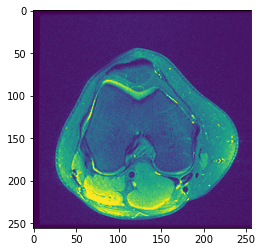

In [6]:
atlas_np = np.load('./MRNet-v1.0/train/axial/{}.npy'.format(resultIndex))
atlas_np = np.pad(atlas_np, ((0, 7), (0, 0), (0, 0)))
atlas_itk = sitk.GetImageFromArray(atlas_np)
print(atlas_np.shape)
print(atlas_itk.GetSize())
print(atlas_itk.GetSpacing())
plt.imshow(atlas_np[20,:,:])

### Expand z-dimension and resize

In [ ]:
# atlas_itk_expanded = sitk.Expand(atlas_itk, [1, 1 ,8], sitk.sitkLinear)
atlas_old_shape = atlas_itk.GetSize()
atlas_old_spacing = atlas_itk.GetSpacing()
atlas_itk_expanded = sitk.Resample(atlas_itk, [atlas_old_shape[0]//2, atlas_old_shape[1]//2, atlas_old_shape[2]*4], sitk.Transform(), \
                                   sitk.sitkNearestNeighbor, atlas_itk.GetOrigin(), \
                                   [atlas_old_spacing[0]*2, atlas_old_spacing[1]*2, atlas_old_spacing[2]/4], \
                                   atlas_itk.GetDirection(), 0.0, atlas_itk.GetPixelID())

example_old_shape = example_itk.GetSize()
example_old_spacing = example_itk.GetSpacing()
example_itk_expanded = sitk.Resample(example_itk, [example_old_shape[0]//2, example_old_shape[1]//2, example_old_shape[2]*4], sitk.Transform(), \
                                   sitk.sitkNearestNeighbor, example_itk.GetOrigin(), \
                                   [example_old_spacing[0]*2, example_old_spacing[1]*2, example_old_spacing[2]/4], \
                                   example_itk.GetDirection(), 0.0, example_itk.GetPixelID())
print(atlas_itk_expanded.GetSize())
print(example_itk_expanded.GetSize())

In [ ]:
atlas_np_expanded = sitk.GetArrayFromImage(atlas_itk_expanded)
example_np_expanded = sitk.GetArrayFromImage(example_itk_expanded)
print(atlas_np_expanded.shape)
print(example_np_expanded.shape)
plt.imshow(atlas_np_expanded[150,:,:])

### Define callback functions for registration process (for ploting registration progress)

In [ ]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []
    
# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

### Initial alignment before registration: align the centers of two volumes and fix the center of rotation to the center of fixed image

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(atlas_itk_expanded, 
                                                      example_itk_expanded, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(example_itk_expanded, atlas_itk_expanded, initial_transform, sitk.sitkLinear, 0.0, example_itk.GetPixelID())

In [ ]:
print(moving_resampled.GetSize())

### Set parameters for registration and perform the registration

In [ ]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

# This actually returns an instance of Transform class
final_transform = registration_method.Execute(sitk.Cast(atlas_itk_expanded, sitk.sitkFloat32), 
                                               sitk.Cast(example_itk_expanded, sitk.sitkFloat32))

### Check transformation we got and apply it to the moving image.

In [ ]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [ ]:
# To perform a transformation, a resampling operation is required in ITK.
moving_resampled = sitk.Resample(example_itk_expanded, atlas_itk_expanded, final_transform, sitk.sitkLinear, 0.0, example_itk_expanded.GetPixelID())
# sitk.WriteImage(moving_resampled, os.path.join('.', 'RIRE_training_001_mr_T1_resampled.mha'))
moving_resampled_np = sitk.GetArrayViewFromImage(moving_resampled)

In [ ]:
print(moving_resampled_np.shape)
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(example_np_expanded[60, :, :])
axes[1].imshow(atlas_np_expanded[110, :, :])
axes[2].imshow(moving_resampled_np[110, :, :])

### Pre-process

In [8]:
atlas_np = np.load('./MRNet-v1.0/train/axial/{}.npy'.format(resultIndex))
atlas_np = np.pad(atlas_np, ((0, 7), (0, 0), (0, 0)))
atlas_itk = sitk.GetImageFromArray(atlas_np)
atlas_old_shape = atlas_itk.GetSize()
atlas_old_spacing = atlas_itk.GetSpacing()
atlas_itk_expanded = sitk.Resample(atlas_itk, [atlas_old_shape[0]//2, atlas_old_shape[1]//2, atlas_old_shape[2]*4], sitk.Transform(), \
                                   sitk.sitkNearestNeighbor, atlas_itk.GetOrigin(), \
                                   [atlas_old_spacing[0]*2, atlas_old_spacing[1]*2, atlas_old_spacing[2]/4], \
                                   atlas_itk.GetDirection(), 0.0, atlas_itk.GetPixelID())

savePath = './MRNet-forVoxelMorph/processedData-rigidTransITK/{}'

for index in allImageIndices:
    curImg_np = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
    curImg_itk = sitk.GetImageFromArray(curImg_np)

    # Expand z-dimension and resize
    curImg_old_shape = curImg_itk.GetSize()
    curImg_old_spacing = curImg_itk.GetSpacing()
    curImg_itk_expanded = sitk.Resample(curImg_itk, [curImg_old_shape[0]//2, curImg_old_shape[1]//2, curImg_old_shape[2]*4], sitk.Transform(), \
                                       sitk.sitkNearestNeighbor, curImg_itk.GetOrigin(), \
                                       [curImg_old_spacing[0]*2, curImg_old_spacing[1]*2, curImg_old_spacing[2]/4], \
                                       curImg_itk.GetDirection(), 0.0, curImg_itk.GetPixelID())
    
    # Initial Alignment
    initial_transform = sitk.CenteredTransformInitializer(atlas_itk_expanded, 
                                                      curImg_itk_expanded, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

    curImg_resampled = sitk.Resample(curImg_itk_expanded, atlas_itk_expanded, initial_transform,
                                     sitk.sitkLinear, 0.0, curImg_itk.GetPixelID())
    
    
    # Registration Settings (put it in loops because initial_transform is different for each pair of images)
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Execute the registration method and get the rigid registration
    final_transform = registration_method.Execute(sitk.Cast(atlas_itk_expanded, sitk.sitkFloat32), 
                                               sitk.Cast(curImg_itk_expanded, sitk.sitkFloat32))
    
    # Apply the rigid transformation
    curImg_resampled_itk = sitk.Resample(curImg_itk_expanded, atlas_itk_expanded, final_transform,
                                         sitk.sitkLinear, 0.0, curImg_itk_expanded.GetPixelID())
    curImg_resampled_np = sitk.GetArrayViewFromImage(curImg_resampled_itk)
    
    # Save the data
    np.savez(savePath.format(index), vol_data = curImg_resampled_np)

In [9]:
# Save atlas
atlas_np_expanded = sitk.GetArrayFromImage(atlas_itk_expanded)
print(atlas_np_expanded.shape)
np.savez('./MRNet-forVoxelMorph/atlas', vol = atlas_np_expanded)

(192, 128, 128)


## Below are older approaches for pre-processing

## Check if moving images' directions are the same as that of atlas and do flipping when necessary

### Load atlas image and sample moving image

In [ ]:
atlas = np.load('./MRNet-v1.0/train/axial/0934.npy')
plt.imshow(atlas[9,:,:])

In [ ]:
example = np.load('./MRNet-v1.0/train/axial/0000.npy')
plt.imshow(example[9,:,:])

### Check what is a reasonable pixel value for boundary

In [ ]:
atlasMidSlice = atlas[26,:,:]
copy = np.copy(atlasMidSlice)
for i in range(20):
    for j in range(20):
        copy[i][j] = 80
plt.imshow(copy)
boundaryValue = 80

### Get the left, right boundaries and the top point

In [ ]:
def getBounds(img):
    leftBound = 0
    rightBound = 255
    
    # Left bound
    shouldBreakOuterLoop = False
    for col in range(img.shape[1]):
        for row in range(img.shape[0]):
            if (img[row][col] >= boundaryValue):
                leftBound = col
                shouldBreakOuterLoop = True
                break
        if (shouldBreakOuterLoop):
            break
    # Right bound
    shouldBreakOuterLoop = False
    col = img.shape[1] - 1
    while (col > 0):
        for row in range(img.shape[0]):
            if (img[row][col] >= boundaryValue):
                rightBound = col
                shouldBreakOuterLoop = True
                break
        if (shouldBreakOuterLoop):
            break
        col -= 1

    return (leftBound, rightBound)

In [ ]:
leftB, rightB = getBounds(atlasMidSlice)
copy1 = np.copy(atlasMidSlice)
for i in range(copy1.shape[0]):
    copy1[i][leftB] = 255
    copy1[i][rightB] = 255
plt.imshow(copy1)

In [ ]:
def getTopPt(img):
    topPtX = 0
    topPtY = 0
    
    shouldBreakOuterLoop = False
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if (img[row][col] >= boundaryValue):
                topPtX = row
                topPtY = col
                shouldBreakOuterLoop = True
                break
        if (shouldBreakOuterLoop):
            break
    return (topPtX, topPtY)

In [ ]:
topPtX, topPtY = getTopPt(atlasMidSlice)
# Draw the vertical mid line
for i in range(copy1.shape[0]):
    copy1[i][math.floor((rightB + leftB) / 2)] = 255

# Draw the top boundary
for j in range(copy1.shape[1]):
    copy1[topPtX][j] = 255
plt.imshow(copy1)

### Define function for checking the direction of the img

In [ ]:
def checkDirection(img):
    leftBound = 0
    rightBound = 255
    topPtX = 0
    topPtY = 0
    
    leftBound, rightBound = getBounds(img)
    topPtX, topPtY = getTopPt(img)
    
    mid = math.floor((leftBound + rightBound) / 2)
    if (topPtY > mid):
        return 'right'
    else:
        return 'left'

### Try on atlas and example moving images

In [ ]:
print(checkDirection(atlasMidSlice))
exampleMidSlice = example[22,:,:]
print(checkDirection(exampleMidSlice))

In [ ]:
exampleFlipped = np.flip(example, 2)
print(exampleFlipped.shape)
print(checkDirection(exampleFlipped[22,:,:]))
plt.imshow(exampleFlipped[22,:,:])

In [ ]:
plt.imshow(example[22,:,:])

### Preprocess the data

In [ ]:
targetSlice = 64
savePath = './MRNet-forVoxelMorph/processedData/{}'
for index in allImageIndices:
    curImg = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
    midSliceIdx = math.floor(curImg.shape[0] / 2)
    if (checkDirection(curImg[midSliceIdx, :, :]) == 'left'):
        curImg = np.flip(curImg, 2)
    
    if (curImg.shape[0] >= targetSlice):
        continue
    else:
        numSliceToPaddle = targetSlice - curImg.shape[0]
        curImg = np.pad(curImg, ((0, numSliceToPaddle), (0, 0), (0, 0)))
        np.savez(savePath.format(index), vol_data = curImg)    

In [ ]:
# There is problem in checking direction after flipping. But I believe filppng is doing its job.
img = np.load('./MRNet-v1.0/train/axial/0062.npy')
midSliceIdx = math.floor(img.shape[0] / 2)
plt.imshow(img[midSliceIdx, :, :])
l, r = getBounds(img[midSliceIdx, :, :])
x, y = getTopPt(img[midSliceIdx, :, :])
print(l, r, x, y)
img_f = np.flip(img, 2)
l, r = getBounds(img_f[midSliceIdx, :, :])
x, y = getTopPt(img_f[midSliceIdx, :, :])
print(l, r, x, y)

In [ ]:
plt.imshow(img_f[midSliceIdx, :, :])

### Old approach to generate data (without flipping)

In [ ]:
# Paddle zeros for all images with fewer slices (discard images with more slices)
targetSlice = 64
savePath = './MRNet-forVoxelMorph/processedData/{}'
with open('./MRNet-v1.0/train-abnormal.csv') as file:
    fileReader = csv.reader(file)
    for row in fileReader:
        index = row[0]
        temp = np.load('./MRNet-v1.0/train/axial/{fname}.npy'.format(fname = index))
        if (temp.shape[0] > targetSlice):
            continue
        else:
            numSliceToPaddle = targetSlice - temp.shape[0]
            temp = np.pad(temp, ((0, numSliceToPaddle), (0, 0), (0, 0)))
            np.savez(savePath.format(index), vol_data = temp)

In [ ]:
# Check if everything is right
for filename in os.listdir('./MRNet-forVoxelMorph/processedData'):
    temp = np.load(savePath.format(filename))['vol_data']
    if (temp.shape != (64, 256, 256)):
        print('error')

In [ ]:
# Convert the atlas npy file into npz file
atlas = np.load('./MRNet-v1.0/train/axial/0934.npy')
atlas = np.pad(atlas, ((0, 12), (0, 0), (0, 0)))
print(atlas.shape)
np.savez('./MRNet-forVoxelMorph/atlas', vol = atlas)

In [ ]:
imgPath = "./MRNet-forVoxelMorph/processedData"